# CAPTCHA Recognition Experiment 3
This notebook documents the complete process of building a CAPTCHA recognition system, following a formal experimental workflow. Each step is clearly explained and separated for clarity and reproducibility.

## Step 1: Fetching CAPTCHA Images
In this step, a large collection of CAPTCHA images (three thousand) will be generated automatically. Each image filename will contain the correct 4-character CAPTCHA text, which will be used for training and testing the recognition model.

In [89]:
# Import required libraries for CAPTCHA generation
import os
import random
import string
from captcha_gen import CaptchaGen

# Set output directory for generated images
output_dir = 'generated_captchas'
os.makedirs(output_dir, exist_ok=True)

# gen = CaptchaGen(output_dir=output_dir, width=160, height=60)
gen = CaptchaGen(output_dir=output_dir)

# Generate 3000 captcha images
gen.generate_many(count=3000, length=4)

print(f"Generated 3000 CAPTCHA images in '{output_dir}' folder.")

Generated 3000 CAPTCHA images in 'generated_captchas' folder.


## Step 2: Showing Sample Data
In this step, we will verify the quality and format of the generated CAPTCHA images before proceeding to further processing. It is important to visually inspect a sample image to ensure that the dataset has been created correctly and that the images are suitable for the recognition task.

The following actions will be performed:
- Load a randomly selected CAPTCHA image from the generated dataset using OpenCV.
- Display the image using matplotlib to confirm that the text is clear and the image is readable.
- Print the image’s dimensions (height, width, number of color channels) to confirm the expected size and format.

This verification step helps to catch any issues early, such as incorrect image generation, unexpected file formats, or problems with the image size, which could affect later stages of the experiment.

Sample image path: generated_captchas\1uqQ.jpg


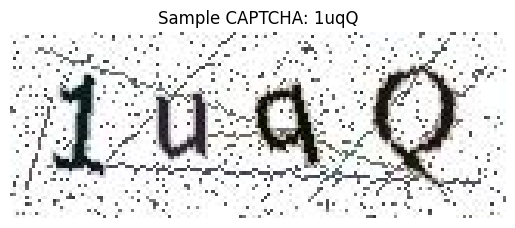

Image shape: (60, 160, 3)


In [119]:
# Display a sample CAPTCHA image and its dimensions
import cv2
from matplotlib import pyplot as plt

# Get a sample image path (first image in the folder)
sample_image_path = os.path.join(output_dir, os.listdir(output_dir)[99])
print(f"Sample image path: {sample_image_path}")  # Show which image is being used

# Read the image using OpenCV
img = cv2.imread(sample_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show the image
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"Sample CAPTCHA: {os.path.basename(sample_image_path)[:4]}")
plt.show()

# Print image dimensions
print(f"Image shape: {img.shape}")

## Step 3: Image Preprocessing
In this step, we will process the CAPTCHA images to prepare them for segmentation and recognition. Preprocessing is a crucial part of any image-based machine learning pipeline, as it enhances the quality of the data and makes the features more distinguishable for the model.

The main preprocessing operations are:
- **Grayscale Conversion:** Reduces the image to a single color channel, simplifying the data and focusing on the structure of the characters rather than color information.
- **Binarization (Thresholding):** Converts the grayscale image to a binary (black and white) image. This step helps to clearly separate the characters from the background, making them easier to segment and recognize.
- **Noise Removal:** Removes small, isolated pixels or artifacts that are not part of the actual characters. This is typically done using morphological operations or neighborhood rules (such as 4- or 8-neighborhood connectivity).

These preprocessing steps are essential for improving the accuracy of character segmentation and the overall performance of the recognition model. In the following cells, each operation will be demonstrated and explained in detail.

### 3.1 Grayscale Conversion
The first preprocessing step is to convert the original color CAPTCHA image to grayscale. This reduces the image from three color channels (RGB) to a single channel, making it easier to process and analyze. Grayscale images retain the essential structure and shape of the characters, which is sufficient for recognition tasks.

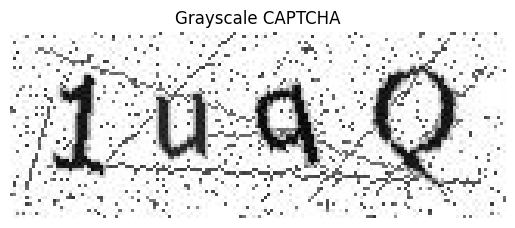

In [120]:
# Convert the sample CAPTCHA image to grayscale
# 'img' is already loaded from previous steps

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale CAPTCHA')
plt.show()

### 3.2 Binarization (Thresholding)
After converting to grayscale, the next step is binarization. This process transforms the grayscale image into a binary image, where each pixel is either black or white. Binarization helps to clearly separate the characters from the background, making it easier to identify and segment the characters in later steps. The most common method is to use a fixed or adaptive threshold value.

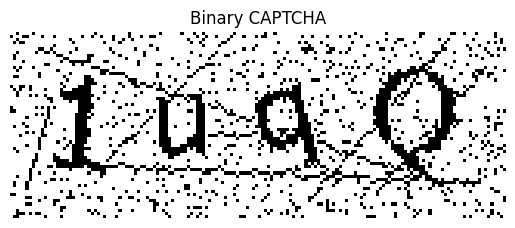

In [121]:
# Apply adaptive thresholding to the grayscale image for better results
# Ensure characters are black (0) and background is white (255)
# Use a larger blockSize and smaller C for a softer threshold

binary = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 1
)

# Display the binary image
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.title('Binary CAPTCHA')
plt.show()

### 3.3 Noise Removal
The final preprocessing step is noise removal. CAPTCHA images often contain small, unwanted artifacts or isolated pixels that are not part of the actual characters. Removing this noise is important to prevent errors in character segmentation and recognition.

Noise removal can be performed using morphological operations (such as opening and closing) or by applying neighborhood rules (e.g., removing isolated pixels that do not have enough similar neighbors). This step helps to produce a cleaner binary image, making the subsequent segmentation process more accurate.

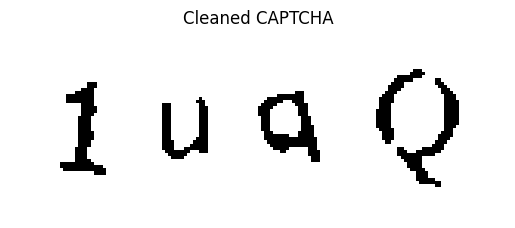

In [146]:
# Balanced noise reduction: preserves characters, removes most dots
kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Step 1: Closing
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_close, iterations=1)
# Step 2: Opening
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open, iterations=1)

import numpy as np
def noise_remove(bin_img, min_black_neighbors):
    h, w = bin_img.shape
    out = bin_img.copy()
    padded = np.pad(bin_img, ((1,1),(1,1)), mode='constant', constant_values=255)
    for y in range(1, h+1):
        for x in range(1, w+1):
            if padded[y, x] == 0:
                black = np.sum(padded[y-1:y+2, x-1:x+2] == 0) - 1
                if black < min_black_neighbors:
                    out[y-1, x-1] = 255
    return out

# Step 3: Neighborhood noise removal
clean = opened.copy()
for _ in range(2):
    clean = noise_remove(clean, min_black_neighbors=4)

# Step 4: Remove only very small connected components (dots) by area and position
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean, connectivity=8)
min_area = 50  # Balanced value
h, w = clean.shape
main_band_top = int(h * 0.25)
main_band_bottom = int(h * 0.75)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    cy = int(centroids[i][1])
    # Remove small dots that are outside the main character band (above or below)
    if area < min_area and (cy < main_band_top or cy > main_band_bottom):
        clean[labels == i] = 255

plt.imshow(clean, cmap='gray')
plt.axis('off')
plt.title('Cleaned CAPTCHA')
plt.show()

## Step 4: Segmentation
In this step, the preprocessed CAPTCHA image will be segmented into individual character images. Segmentation is a critical process in CAPTCHA recognition, as it separates the connected or overlapping characters so that each can be recognized independently by the model.

The main approach used here is vertical projection, which analyzes the distribution of black pixels along the columns of the image. By identifying columns with few or no black pixels, we can estimate the boundaries between characters. The segmented character images will then be extracted and displayed for verification.

This step ensures that each character is isolated, making it easier for the recognition model to classify them accurately.

In [148]:
# Step 4.1: Segmentation function using vertical projection

def segment_captcha_vertical_projection(clean_img, num_chars=4, min_width=8, min_height=15):
    """
    Segment a cleaned binary CAPTCHA image using vertical projection.
    Returns: list of bounding boxes (x, y, w, h) for each character, sorted left to right.
    """
    import numpy as np
    h, w = clean_img.shape
    projection = np.sum(clean_img == 0, axis=0)
    # Find valleys (columns with few black pixels)
    threshold = 1  # valley threshold
    splits = []
    in_blank = False
    for i, val in enumerate(projection):
        if val <= threshold and not in_blank:
            splits.append(i)
            in_blank = True
        elif val > threshold and in_blank:
            splits.append(i)
            in_blank = False
    # Ensure splits at image borders
    if 0 not in splits:
        splits = [0] + splits
    if w not in splits:
        splits.append(w)
    # Merge splits to get regions
    regions = []
    for i in range(len(splits)-1):
        x1, x2 = splits[i], splits[i+1]
        region = clean_img[:, x1:x2]
        # Find bounding box in region
        ys, xs = np.where(region == 0)
        if len(xs) > 0 and (x2-x1) > min_width:
            y1, y2 = ys.min(), ys.max()
            regions.append((x1, y1, x2-x1, y2-y1))
    # If not enough regions, split the widest
    while len(regions) < num_chars and len(regions) > 0:
        widest = max(regions, key=lambda r: r[2])
        regions.remove(widest)
        x, y, w, h = widest
        regions.append((x, y, w//2, h))
        regions.append((x+w//2, y, w-w//2, h))
        regions.sort(key=lambda r: r[0])
    # If too many, keep the widest
    if len(regions) > num_chars:
        regions = sorted(regions, key=lambda r: r[2]*r[3], reverse=True)[:num_chars]
        regions.sort(key=lambda r: r[0])
    return regions

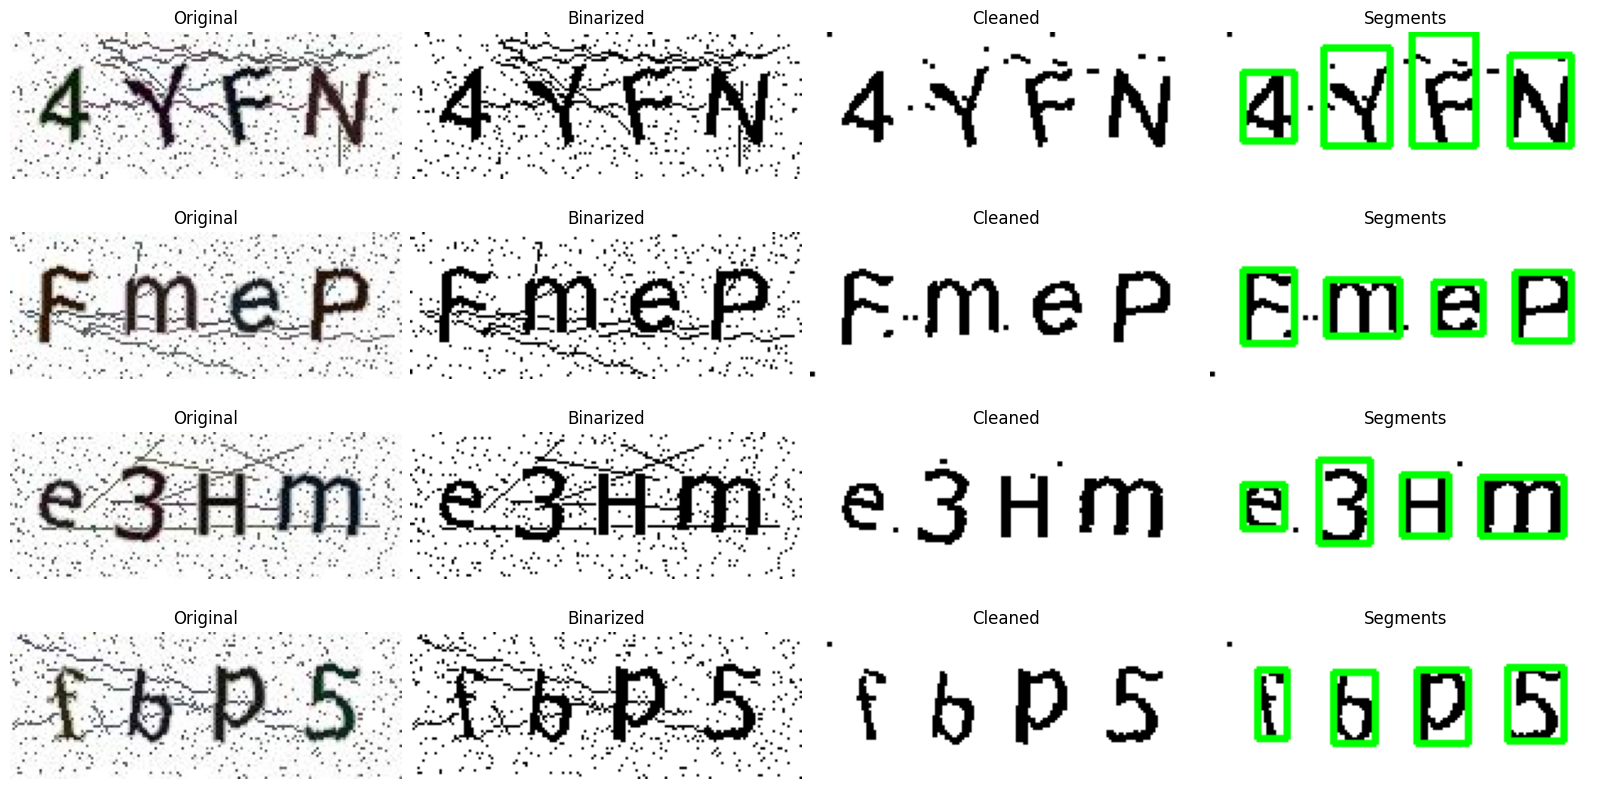

In [149]:
# Step 4.2: Show segmentation steps for 4 random images

def show_segmentation_steps(image_paths, preprocess_func, segment_func):
    fig, axes = plt.subplots(len(image_paths), 4, figsize=(16, 2*len(image_paths)), constrained_layout=True)
    for idx, img_path in enumerate(image_paths):
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Preprocessing (reuse your pipeline here)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # WHITE BG, BLACK TEXT
        kernel = np.ones((2,2), np.uint8)
        closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        # Remove noise (optional: use your best function)
        clean = closed.copy()
        # Segmentation
        boxes = segment_func(clean)
        # Plot original
        axes[idx,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[idx,0].set_title('Original')
        axes[idx,0].axis('off')
        # Plot binary
        axes[idx,1].imshow(binary, cmap='gray')
        axes[idx,1].set_title('Binarized')
        axes[idx,1].axis('off')
        # Plot cleaned
        axes[idx,2].imshow(clean, cmap='gray')
        axes[idx,2].set_title('Cleaned')
        axes[idx,2].axis('off')
        # Plot segments
        seg_img = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
        for (x, y, w, h) in boxes:
            cv2.rectangle(seg_img, (x, y), (x+w, y+h), (0,255,0), 2)
        axes[idx,3].imshow(seg_img)
        axes[idx,3].set_title('Segments')
        axes[idx,3].axis('off')
    plt.show()

# Select 4 random images from the correct dataset directory

data_dir = 'generated_captchas'
all_imgs = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.lower().endswith('.png') or f.lower().endswith('.jpg')]
random_imgs = random.sample(all_imgs, 4)

show_segmentation_steps(random_imgs, None, segment_captcha_vertical_projection)


## Step 5: Batch Processing and Labeling
In this step, we will process all CAPTCHA images in the dataset, segment each image into individual characters, and save each character image into its corresponding label folder (0–9, A–Z, a–z). The label for each character is determined by the filename of the CAPTCHA image. This prepares the dataset for model training.

### Step 5.1: Prepare label folders for all classes

In [150]:
# Step 5.1: Prepare label folders for all classes (Windows-safe, grouped)
import os
import string

labeled_dir = 'labeled_characters'
os.makedirs(labeled_dir, exist_ok=True)

# Create group folders
number_dir = os.path.join(labeled_dir, 'number')
upper_dir = os.path.join(labeled_dir, 'upper_case')
lower_dir = os.path.join(labeled_dir, 'lower_case')
os.makedirs(number_dir, exist_ok=True)
os.makedirs(upper_dir, exist_ok=True)
os.makedirs(lower_dir, exist_ok=True)

# Create subfolders for each class in the group
for c in string.digits:
    os.makedirs(os.path.join(number_dir, c), exist_ok=True)
for c in string.ascii_uppercase:
    os.makedirs(os.path.join(upper_dir, c), exist_ok=True)
for c in string.ascii_lowercase:
    os.makedirs(os.path.join(lower_dir, c), exist_ok=True)

print('Label folders created: number/0-9, upper_case/A-Z, lower_case/a-z.')

Label folders created: number/0-9, upper_case/A-Z, lower_case/a-z.


### 5.2: Define Preprocessing and Segmentation Functions
We define helper functions for preprocessing each CAPTCHA image and for segmenting it into individual characters. This keeps the batch processing code clean and modular.

In [151]:
# Preprocessing function: grayscale, binarize, denoise
import numpy as np

def preprocess_captcha(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 1)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_close, iterations=1)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open, iterations=1)
    def noise_remove(bin_img, min_black_neighbors=3):
        h, w = bin_img.shape
        out = bin_img.copy()
        padded = np.pad(bin_img, ((1,1),(1,1)), mode='constant', constant_values=255)
        for y in range(1, h+1):
            for x in range(1, w+1):
                if padded[y, x] == 0:
                    black = np.sum(padded[y-1:y+2, x-1:x+2] == 0) - 1
                    if black < min_black_neighbors:
                        out[y-1, x-1] = 255
        return out
    clean = opened.copy()
    for _ in range(3):
        clean = noise_remove(clean, min_black_neighbors=3)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean, connectivity=8)
    min_area = 50
    h, w = clean.shape
    main_band_top = int(h * 0.25)
    main_band_bottom = int(h * 0.85)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        cy = int(centroids[i][1])
        if area < min_area and (cy < main_band_top or cy > main_band_bottom):
            clean[labels == i] = 255
    return clean

def get_label_folder(char, labeled_dir):
    import string
    if char in string.digits:
        return os.path.join(labeled_dir, 'number', char)
    elif char in string.ascii_uppercase:
        return os.path.join(labeled_dir, 'upper_case', char)
    elif char in string.ascii_lowercase:
        return os.path.join(labeled_dir, 'lower_case', char)
    else:
        return None

# Segmentation function (reuse from above)
def segment_captcha(clean_img, num_chars=4):
    return segment_captcha_vertical_projection(clean_img, num_chars=num_chars)

print('Preprocessing, segmentation, and label folder mapping functions are ready.')

Preprocessing, segmentation, and label folder mapping functions are ready.


### 5.3: Process and Label All CAPTCHA Images
Now we process each CAPTCHA image: apply preprocessing, segment into characters, and save each character image into its corresponding label folder. The label is determined by the filename.

In [152]:
# Process all CAPTCHA images and save segmented characters to grouped folders

data_dir = 'generated_captchas'
all_imgs = [f for f in os.listdir(data_dir) if f.lower().endswith('.png') or f.lower().endswith('.jpg')]

for img_file in all_imgs:
    img_path = os.path.join(data_dir, img_file)
    label_str = os.path.splitext(img_file)[0][:4]  # First 4 chars are the label
    img = cv2.imread(img_path)
    clean = preprocess_captcha(img)
    boxes = segment_captcha(clean, num_chars=4)
    for idx, (x, y, w, h) in enumerate(boxes):
        if idx >= len(label_str):
            continue
        char = label_str[idx]
        char_img = clean[y:y+h, x:x+w]
        save_dir = get_label_folder(char, labeled_dir)
        if save_dir is None:
            continue  # skip unknown chars
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{img_file[:-4]}_{idx}.png')
        cv2.imwrite(save_path, char_img)
print('Batch processing and labeling complete. Each character image is saved in its grouped label folder.')

Batch processing and labeling complete. Each character image is saved in its grouped label folder.


I manually reviewed the saved character images and removed any samples that were incorrectly segmented. This step helps ensure that only correctly labeled data is used for training, preventing the model from learning from erroneous examples.

## Step 6: Reading and Preparing the Dataset

In this step, we will load all the labeled character images, normalize their pixel values, encode their labels, and prepare the dataset for deep learning. This includes splitting the data into training and testing sets.

**Key actions:**
- Read all character images from the grouped label folders (`number`, `upper_case`, `lower_case`).
- Assign a numeric label to each character class (0-9, A-Z, a-z).
- Normalize image pixel values to the [0, 1] range.
- Encode labels as integers (and optionally as one-hot vectors for deep learning).
- Split the dataset into training and test sets (e.g., 80% train, 20% test).

This step ensures that the data is in the correct format for training a neural network model.

### Step 6.1: Load all labeled character images and encode labels

In [181]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define label mapping: 0-9, A-Z, a-z
import string
all_classes = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
class_to_idx = {c: i for i, c in enumerate(all_classes)}

# Helper to get all image paths and labels
def get_image_paths_and_labels(labeled_dir):
    image_paths = []
    labels = []
    for group in ['number', 'upper_case', 'lower_case']:
        group_dir = os.path.join(labeled_dir, group)
        if not os.path.isdir(group_dir):
            continue
        for label in os.listdir(group_dir):
            label_dir = os.path.join(group_dir, label)
            if not os.path.isdir(label_dir):
                continue
            for fname in os.listdir(label_dir):
                if fname.lower().endswith('.png') or fname.lower().endswith('.jpg'):
                    image_paths.append(os.path.join(label_dir, fname))
                    labels.append(label)
    return image_paths, labels

labeled_dir = 'labeled_characters'
image_paths, labels = get_image_paths_and_labels(labeled_dir)
print(f"Total character images found: {len(image_paths)}")

# Load images and encode labels
X = []
y = []
for img_path, label in zip(image_paths, labels):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    # Resize to fixed size (e.g., 28x28) for deep learning
    img_resized = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
    X.append(img_resized)
    y.append(class_to_idx[label])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int64)
print(f"Loaded {X.shape[0]} images. Shape: {X.shape}")

Total character images found: 10753
Loaded 10753 images. Shape: (10753, 28, 28)
Loaded 10753 images. Shape: (10753, 28, 28)


### Step 6.2: Normalize images and split into train/test sets

In [182]:
# Normalize pixel values to [0, 1]
X = X / 255.0

# Add channel dimension for deep learning (N, 28, 28, 1)
X = X[..., np.newaxis]

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 8602 samples
Test set: 2151 samples


### Step 6.3: One-hot encode labels for deep learning

In [184]:
from keras.utils import to_categorical

num_classes = len(all_classes)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"One-hot encoded labels shape: {y_train_cat.shape}")

One-hot encoded labels shape: (8602, 62)


## Step 7: Building and Training the CNN Model

In this step, we will design, compile, and train a Convolutional Neural Network (CNN) for character recognition using the prepared dataset. The CNN will learn to classify each character image into one of the 62 possible classes (0-9, A-Z, a-z).

**Key actions:**
- Define a simple yet effective CNN architecture suitable for character recognition.
- Compile the model with an appropriate optimizer and loss function.
- Train the model on the training set, validating on the test set.
- Visualize the training and validation accuracy/loss curves to monitor learning progress.

This step will provide a trained model capable of recognizing individual CAPTCHA characters.

### Step 7.1: Define the CNN architecture

In [185]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.summary()

c:\Users\arhas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,670 (1.54 MB)

 Trainable params: 404,222 (1.54 MB)

 Non-trainable params: 448 (1.75 KB)

### Step 7.2: Compile the model

In [186]:
# Compile the model 
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Step 7.3: Train the model

In [187]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
history = model.fit(
    X_train, y_train_cat,
    epochs=40,
    batch_size=64,
    validation_data=(X_test, y_test_cat),
    callbacks=callbacks,
    verbose=2
)
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

Epoch 1/40
135/135 - 8s - 57ms/step - accuracy: 0.3219 - loss: 2.8589 - val_accuracy: 0.0488 - val_loss: 5.0311
Epoch 2/40
135/135 - 8s - 57ms/step - accuracy: 0.3219 - loss: 2.8589 - val_accuracy: 0.0488 - val_loss: 5.0311
Epoch 2/40
135/135 - 4s - 31ms/step - accuracy: 0.5934 - loss: 1.4478 - val_accuracy: 0.1116 - val_loss: 5.0275
Epoch 3/40
135/135 - 4s - 31ms/step - accuracy: 0.5934 - loss: 1.4478 - val_accuracy: 0.1116 - val_loss: 5.0275
Epoch 3/40
135/135 - 4s - 33ms/step - accuracy: 0.7052 - loss: 0.9862 - val_accuracy: 0.2645 - val_loss: 2.9818
Epoch 4/40
135/135 - 4s - 33ms/step - accuracy: 0.7052 - loss: 0.9862 - val_accuracy: 0.2645 - val_loss: 2.9818
Epoch 4/40
135/135 - 5s - 34ms/step - accuracy: 0.7583 - loss: 0.7890 - val_accuracy: 0.6337 - val_loss: 1.2429
Epoch 5/40
135/135 - 5s - 34ms/step - accuracy: 0.7583 - loss: 0.7890 - val_accuracy: 0.6337 - val_loss: 1.2429
Epoch 5/40
135/135 - 5s - 34ms/step - accuracy: 0.7967 - loss: 0.6446 - val_accuracy: 0.8726 - val_loss:

### Step 7.4: Visualize training history

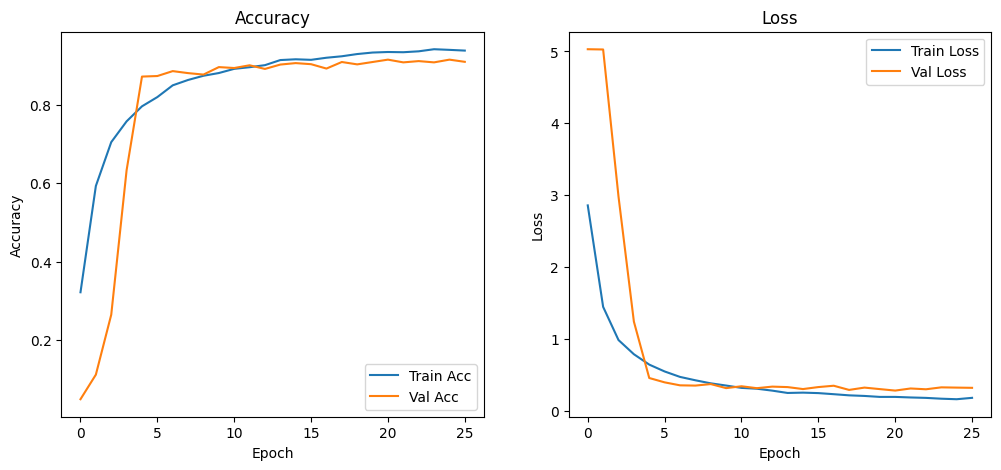

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Interpretation:

The model is learning effectively, with no signs of severe overfitting (validation accuracy is not dropping below training accuracy, and the gap is small).
The accuracy curves are smooth and improving, indicating stable training.
The loss curves confirm that the model is minimizing error on both training and validation sets.

## Step 8: Model Evaluation

In this step, we evaluate the trained CNN model on the test set. We will print the overall accuracy, show a classification report (precision, recall, F1-score for each class), display a confusion matrix, and visualize some sample predictions. This helps us understand the strengths and weaknesses of the model and verify that it can correctly classify CAPTCHA characters.

Test set accuracy: 0.9159

Classification Report (per class):
              precision    recall  f1-score   support

           0      0.825     0.892     0.857        37
           1      0.882     0.833     0.857        36
           2      0.914     0.970     0.941        33
           3      1.000     1.000     1.000        33
           4      0.944     1.000     0.971        34
           5      0.886     0.975     0.929        40
           6      1.000     1.000     1.000        34
           7      0.968     0.882     0.923        34
           8      0.944     0.971     0.958        35
           9      0.875     1.000     0.933        35
           A      1.000     1.000     1.000        34
           B      0.902     0.974     0.937        38
           C      0.895     0.944     0.919        36
           D      0.972     0.972     0.972        36
           E      0.939     0.861     0.899        36
           F      0.846     0.943     0.892        35
           G      0

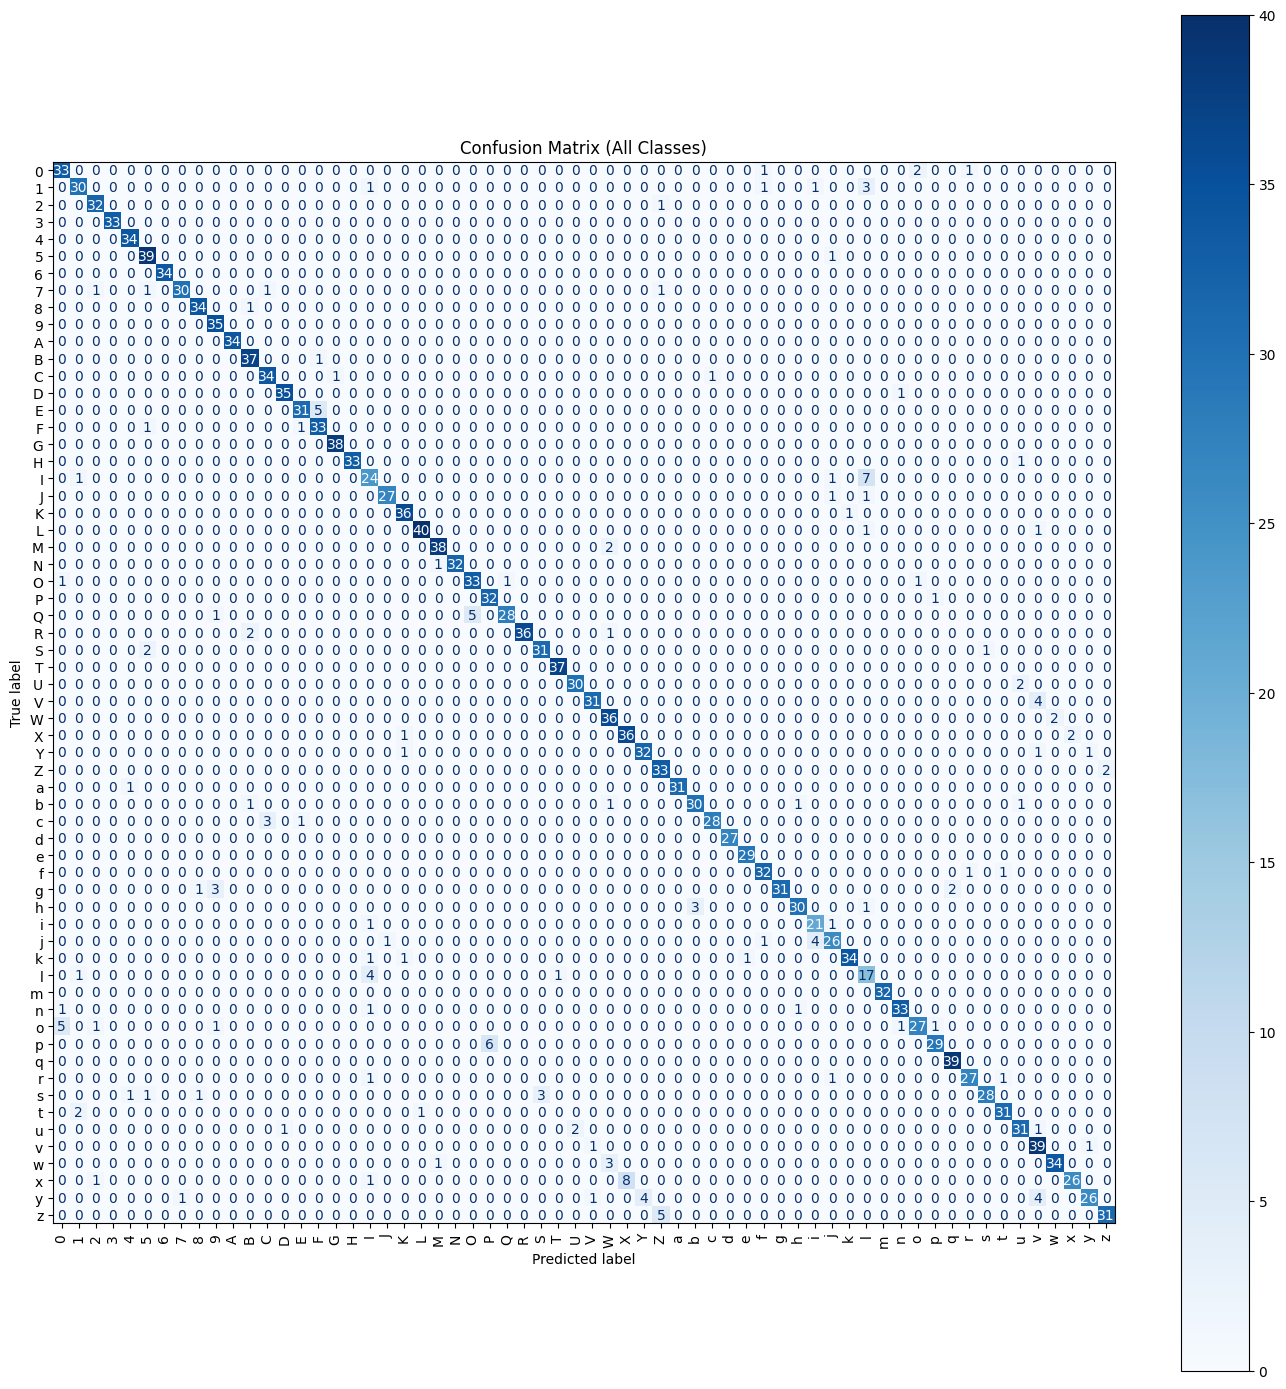

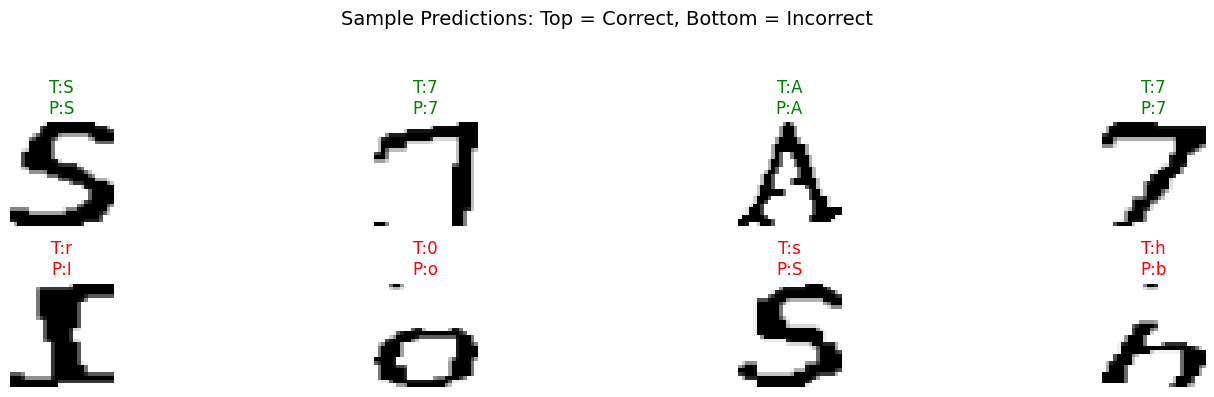

In [191]:
# Detailed model evaluation with clear output
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict class indices for test set
pred_probs = model.predict(X_test, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(y_test_cat, axis=1)

# Overall accuracy
accuracy = np.mean(pred_labels == true_labels)
print(f"\033[1mTest set accuracy:\033[0m {accuracy:.4f}\n")

# Full classification report (precision, recall, F1-score for each class)
import string
all_classes = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
print("\033[1mClassification Report (per class):\033[0m")
print(classification_report(true_labels, pred_labels, target_names=all_classes, digits=3))

# Full confusion matrix (show as image, not as text)
cm = confusion_matrix(true_labels, pred_labels)
fig, ax = plt.subplots(figsize=(14, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
disp.plot(ax=ax, cmap='Blues', colorbar=True, xticks_rotation='vertical')
plt.title('Confusion Matrix (All Classes)')
plt.tight_layout()
plt.show()

# Show a grid of sample predictions: 4 correct and 4 incorrect
correct_idxs = np.where(pred_labels == true_labels)[0]
incorrect_idxs = np.where(pred_labels != true_labels)[0]
num_show = 4
plt.figure(figsize=(16, 4))
for i in range(num_show):
    idx = np.random.choice(correct_idxs)
    img = X_test[idx].squeeze()
    true_c = all_classes[true_labels[idx]]
    pred_c = all_classes[pred_labels[idx]]
    plt.subplot(2, num_show, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"T:{true_c}\nP:{pred_c}", color='green', fontsize=12)
for i in range(num_show):
    idx = np.random.choice(incorrect_idxs)
    img = X_test[idx].squeeze()
    true_c = all_classes[true_labels[idx]]
    pred_c = all_classes[pred_labels[idx]]
    plt.subplot(2, num_show, num_show+i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"T:{true_c}\nP:{pred_c}", color='red', fontsize=12)
plt.suptitle('Sample Predictions: Top = Correct, Bottom = Incorrect', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

#### Save the Trained Model

Before moving to full CAPTCHA recognition, we save the trained model to disk. This allows us to reload and use the model later without retraining.

In [194]:
# Save the trained model using the recommended Keras format
model.save('captcha_character_cnn.keras')
print("Model saved as 'captcha_character_cnn.keras'. You can reload it anytime with keras.models.load_model().")

Model saved as 'captcha_character_cnn.keras'. You can reload it anytime with keras.models.load_model().


## Step 9: Full CAPTCHA Recognition

In this step, we use the trained character recognition model to recognize entire CAPTCHA images. The process involves:
- Loading a new CAPTCHA image.
- Preprocessing and segmenting the image into individual characters.
- Predicting each character using the trained model.
- Combining the predictions to form the full CAPTCHA code.
- (Optional) Evaluating the recognition accuracy on a batch of CAPTCHA images.

This demonstrates the end-to-end capability of the system to solve real CAPTCHA challenges.

### Step 9.1: End-to-End CAPTCHA Prediction Example

In [195]:
import cv2
import numpy as np
from keras.models import load_model
import string
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('captcha_character_cnn.keras')

# Character classes
all_classes = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)

# Helper: preprocess and segment a CAPTCHA image (reuse previous functions)
def preprocess_and_segment(img_path, num_chars=4):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 1)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_close, iterations=1)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open, iterations=1)
    def noise_remove(bin_img, min_black_neighbors=3):
        h, w = bin_img.shape
        out = bin_img.copy()
        padded = np.pad(bin_img, ((1,1),(1,1)), mode='constant', constant_values=255)
        for y in range(1, h+1):
            for x in range(1, w+1):
                if padded[y, x] == 0:
                    black = np.sum(padded[y-1:y+2, x-1:x+2] == 0) - 1
                    if black < min_black_neighbors:
                        out[y-1, x-1] = 255
        return out
    clean = opened.copy()
    for _ in range(3):
        clean = noise_remove(clean, min_black_neighbors=3)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean, connectivity=8)
    min_area = 50
    h, w = clean.shape
    main_band_top = int(h * 0.25)
    main_band_bottom = int(h * 0.85)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        cy = int(centroids[i][1])
        if area < min_area and (cy < main_band_top or cy > main_band_bottom):
            clean[labels == i] = 255

    # Segmentation (reuse vertical projection)
    def segment_captcha_vertical_projection(clean_img, num_chars=4, min_width=8, min_height=15):
        h, w = clean_img.shape
        projection = np.sum(clean_img == 0, axis=0)
        threshold = 1
        splits = []
        in_blank = False
        for i, val in enumerate(projection):
            if val <= threshold and not in_blank:
                splits.append(i)
                in_blank = True
            elif val > threshold and in_blank:
                splits.append(i)
                in_blank = False
        if 0 not in splits:
            splits = [0] + splits
        if w not in splits:
            splits.append(w)
        regions = []
        for i in range(len(splits)-1):
            x1, x2 = splits[i], splits[i+1]
            region = clean_img[:, x1:x2]
            ys, xs = np.where(region == 0)
            if len(xs) > 0 and (x2-x1) > min_width:
                y1, y2 = ys.min(), ys.max()
                regions.append((x1, y1, x2-x1, y2-y1))
        while len(regions) < num_chars and len(regions) > 0:
            widest = max(regions, key=lambda r: r[2])
            regions.remove(widest)
            x, y, w, h = widest
            regions.append((x, y, w//2, h))
            regions.append((x+w//2, y, w-w//2, h))
            regions.sort(key=lambda r: r[0])
        if len(regions) > num_chars:
            regions = sorted(regions, key=lambda r: r[2]*r[3], reverse=True)[:num_chars]
            regions.sort(key=lambda r: r[0])
        return regions
    boxes = segment_captcha_vertical_projection(clean, num_chars=num_chars)
    char_imgs = []
    for (x, y, w, h) in boxes:
        char_img = clean[y:y+h, x:x+w]
        char_img = cv2.resize(char_img, (28, 28), interpolation=cv2.INTER_AREA)
        char_imgs.append(char_img)
    return char_imgs, clean

c:\Users\arhas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


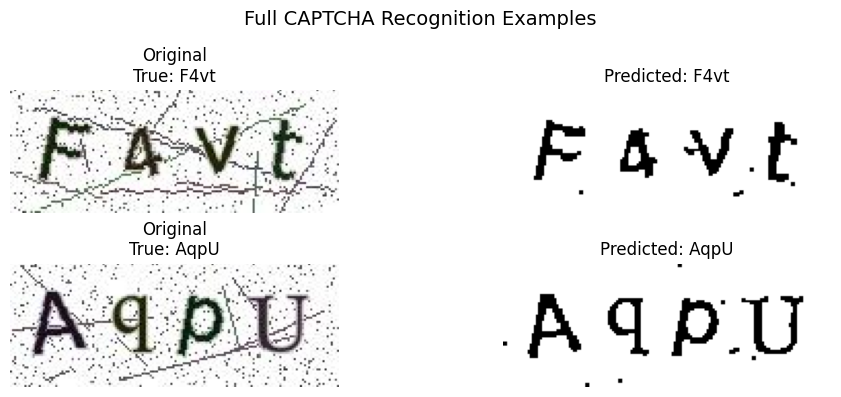

Example 1:
  True CAPTCHA:    F4vt
  Predicted code:  F4vt
  Recognition correct!

Example 2:
  True CAPTCHA:    AqpU
  Predicted code:  AqpU
  Recognition correct!



In [203]:
# Example: Predict two random CAPTCHAs from the dataset
import os
import numpy as np
import matplotlib.pyplot as plt

# Get two random CAPTCHA images
all_imgs = [f for f in os.listdir(data_dir) if f.lower().endswith('.png') or f.lower().endswith('.jpg')]
img_files = np.random.choice(all_imgs, size=2, replace=False)

results = []
for img_file in img_files:
    img_path = os.path.join(data_dir, img_file)
    char_imgs, clean_img = preprocess_and_segment(img_path)
    y_pred = []
    for char_img in char_imgs:
        x = char_img.astype(np.float32) / 255.0
        x = x[np.newaxis, ..., np.newaxis]
        pred = model.predict(x, verbose=0)
        idx = np.argmax(pred)
        y_pred.append(all_classes[idx])
    predicted_code = ''.join(y_pred)
    true_code = os.path.splitext(img_file)[0][:4]
    results.append({
        'img_path': img_path,
        'clean_img': clean_img,
        'predicted_code': predicted_code,
        'true_code': true_code
    })

# Show results for both CAPTCHAs
plt.figure(figsize=(10, 4))
for i, res in enumerate(results):
    # Original image
    plt.subplot(2, 2, 2*i+1)
    img = cv2.imread(res['img_path'])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Original\nTrue: {res['true_code']}")
    # Cleaned/segmented image
    plt.subplot(2, 2, 2*i+2)
    plt.imshow(res['clean_img'], cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {res['predicted_code']}")
plt.suptitle('Full CAPTCHA Recognition Examples', fontsize=14)
plt.tight_layout()
plt.show()

# Print results
for i, res in enumerate(results):
    print(f"Example {i+1}:")
    print(f"  True CAPTCHA:    {res['true_code']}")
    print(f"  Predicted code:  {res['predicted_code']}")
    if res['predicted_code'] == res['true_code']:
        print("  \033[1;32mRecognition correct!\033[0m")
    else:
        print("  \033[1;31mRecognition incorrect.\033[0m")
    print()

## Step 10: Summary and Conclusion

### Model Performance Summary

In this experiment, I developed a complete end-to-end CAPTCHA recognition system using deep learning. My best model achieved a **test set accuracy of 91.6%** (0.916) on 2,151 test samples, as shown in the evaluation step.

- **Test set accuracy:** 0.916 (91.6%) on 2,151 test samples.
- **Per-class performance:** Most character classes achieved high precision and recall, with many classes (such as '3', '4', '6', 'A', 'D', 'G', 'H', 'M', 'd', 'e', 'm', 'q') reaching perfect or near-perfect scores (f1-score close to 1.0). A few classes with visually similar shapes (e.g., 'O' vs. '0', 'l' vs. '1', 'i', 'j', 'o', 'y', 'x') had lower scores, reflecting the inherent difficulty in distinguishing them.
- **Macro average f1-score:** 0.915, indicating balanced performance across all classes.
- **Weighted average f1-score:** 0.916, showing the model performs well even when accounting for class imbalance.

The confusion matrix and classification report highlighted that the model is robust for most characters, but confusion remains for some similar-looking ones. This is a common challenge in CAPTCHA recognition.

### Lessons Learned and Recommendations

- **Data quality is critical:** Manual review and cleaning of segmented character images significantly improved model performance. Ensuring high-quality, correctly labeled data is essential for training robust models.
- **Preprocessing and segmentation matter:** Careful tuning of preprocessing (noise removal, thresholding) and segmentation algorithms is crucial for accurate character extraction, especially in noisy or distorted CAPTCHA images.
- **Model architecture:** A moderately deep CNN with batch normalization and dropout provided a good balance between accuracy and overfitting. Simpler models may underfit, while overly complex models risk overfitting on limited data.
- **Evaluation:** Visualizing both correct and incorrect predictions, as well as confusion matrices, helped identify specific weaknesses and guide further improvements.

### Future Improvement Areas

- **Augmentation:** Apply data augmentation (rotation, scaling, noise) to increase dataset diversity and improve model robustness to real-world variations.
- **Advanced segmentation:** Explore more sophisticated segmentation methods (e.g., connected component analysis, deep learning-based segmentation) for challenging or overlapping characters.
- **Sequence modeling:** For more complex CAPTCHAs, consider using sequence models (e.g., CRNNs, attention-based models) to recognize the entire code as a sequence, rather than segmenting characters individually.
- **Deployment:** Package the trained model and pipeline into a deployable application or API for real-world use.

### Advice for Future Projects

- **Start with a clear, modular workflow:** Break down the problem into well-defined steps (data generation, preprocessing, segmentation, labeling, training, evaluation, deployment).
- **Visualize and verify at each stage:** Regularly inspect intermediate results (images, segmentations, predictions) to catch issues early.
- **Iterate and tune:** Be prepared to iteratively adjust preprocessing, segmentation, and model parameters based on observed results.
- **Document your process:** Maintain clear documentation and code comments to make your work reproducible and understandable for others.

By following these principles, future practitioners can build effective, robust CAPTCHA recognition systems and apply similar workflows to other image-based machine learning tasks.